In [123]:
import arviz as az
import itertools
import bambi as bmb
import numpy as np
import matplotlib.pyplot as plt
import seaborn.objects as so
import seaborn as sns
import pandas as pd

from bambi.plots import plot_cap
from bambi.plots.plot_cap import make_main_values
from bambi.utils import listify, clean_formula_lhs

## Gaussian Linear Model

For the first demonstration, we will use a Gaussian linear regression model to better understand the `plot_cap` function and its arguments. 

In [329]:
# Load data
data = bmb.load_data('mtcars')
data["cyl"] = data["cyl"].replace({4: "low", 6: "medium", 8: "high"})
data["gear"] = data["gear"].replace({3: "A", 4: "B", 5: "C"})
data["cyl"] = pd.Categorical(data["cyl"], categories=["low", "medium", "high"], ordered=True)
#data["drat"] = pd.Categorical(data["drat"], ordered=True).codes

# Define and fit the Bambi model
model = bmb.Model("mpg ~ hp * drat * am", data)
idata = model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mpg_sigma, Intercept, hp, drat, hp:drat, am, hp:am, drat:am, hp:drat:am]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [330]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,13.199,13.415,-13.335,37.366,0.354,0.251,1435.0,1685.0,1.00
hp,-0.014,0.084,-0.179,0.141,0.002,0.002,1331.0,1775.0,1.01
drat,3.735,3.797,-3.023,11.266,0.101,0.073,1410.0,1726.0,1.00
hp:drat,-0.012,0.025,-0.057,0.037,0.001,0.000,1348.0,1806.0,1.00
am,2.029,14.087,-22.234,30.039,0.358,0.253,1550.0,2032.0,1.00
hp:am,0.055,0.089,-0.112,0.220,0.002,0.002,1469.0,2046.0,1.00
drat:am,0.357,3.614,-6.505,6.869,0.098,0.069,1357.0,1737.0,1.00
hp:drat:am,-0.013,0.025,-0.056,0.035,0.001,0.000,1378.0,2069.0,1.00
mpg_sigma,3.079,0.449,2.311,3.940,0.009,0.006,2715.0,2410.0,1.00


In [331]:
datagrid_1 = pd.DataFrame({
    "hp": data.hp,
    "drat": data.drat,
    "am": data.am
})

datagrid_2 = pd.DataFrame({
    "hp": data.hp + 0.01,
    "drat": data.drat,
    "am": data.am
})

In [332]:
# original
preds = model.predict(idata, data=datagrid_1, kind="mean", inplace=False)
preds_mu = preds.posterior.mpg_mean.mean(("chain", "draw"))

# datagrid preds
grid_preds = model.predict(idata, data=datagrid_2, kind="mean", inplace=False)
grid_preds_mu = grid_preds.posterior.mpg_mean.mean(("chain", "draw"))

# comparisons
comparisons = preds_mu - grid_preds_mu
comparisons_std = np.std(comparisons).to_numpy()

In [333]:
comparisons_df = pd.DataFrame({
    "drat": data.drat,
    "upper": comparisons + comparisons_std,
    "lower": comparisons - comparisons_std,
    "am": data.am,
    "comparisons": comparisons,
    "preds_mu": preds_mu,
    "grid_preds_mu": grid_preds_mu
})

comparisons_df = comparisons_df.sort_values(by="drat").reset_index(drop=True)

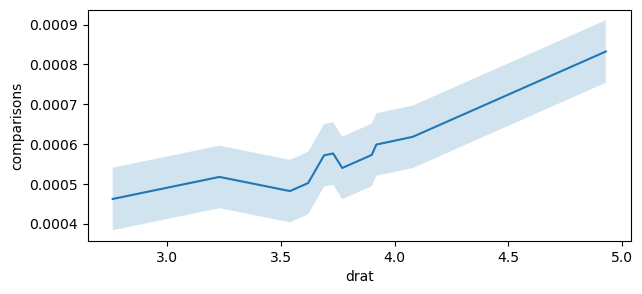

In [334]:
plt.figure(figsize=(7, 3))
sns.lineplot(x=comparisons_df.drat, y=comparisons_df.comparisons)
plt.fill_between(comparisons_df.drat, comparisons_df.upper, comparisons_df.lower, alpha=0.2)

In [102]:
# Define and fit the Bambi model
model = bmb.Model("mpg ~ hp * wt", data)
idata = model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mpg_sigma, Intercept, hp, wt, hp:wt]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [103]:
# original
preds = model.predict(idata, kind="mean", inplace=False)
mean_preds = preds.posterior.mpg_mean.mean(("chain", "draw"))
mean_std = preds.posterior.mpg_mean.std(("chain", "draw"))

In [106]:
new_grid = {
    'hp': data.hp + 10, 
    'wt': data.wt
    }
new_grid = pd.DataFrame.from_dict(new_grid)

preds_new = model.predict(
    idata,
    "mean",
    new_grid,
    inplace=False
)

mean_preds_new = preds_new.posterior.mpg_mean.mean(("chain", "draw"))
mean_std_new = preds_new.posterior.mpg_mean.std(("chain", "draw"))

In [143]:
diff = mean_preds_new - mean_preds
std = np.std(diff) # really the average std

In [135]:
comparison_df = pd.DataFrame({
    "diff": diff,
    "upper": diff + std.to_numpy(),
    "lower": diff - std.to_numpy(),
    "wt": data.wt
})
comparison_df = comparison_df.sort_values(by="wt").reset_index(drop=True)

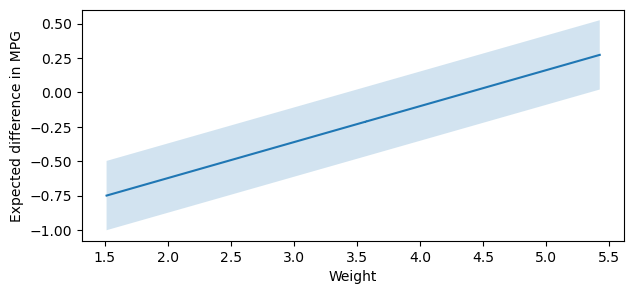

In [137]:
plt.figure(figsize=(7, 3))
plt.plot(comparison_df.wt, comparison_df["diff"])
plt.fill_between(
    comparison_df.wt,
    comparison_df["upper"],
    comparison_df["lower"],
    alpha=0.2
)
plt.xlabel("Weight")
plt.ylabel("Expected difference in MPG");

### Palmer penguins

In [2]:
data = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/palmerpenguins/penguins.csv", index_col=0)

In [3]:
data = data.dropna(axis=0, how="any")

In [4]:
model = bmb.Model(
    "body_mass_g ~ flipper_length_mm * species * bill_length_mm + island",
    data, family="gaussian"
)
idata = model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [body_mass_g_sigma, Intercept, flipper_length_mm, species, flipper_length_mm:species, bill_length_mm, flipper_length_mm:bill_length_mm, species:bill_length_mm, flipper_length_mm:species:bill_length_mm, island]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 145 seconds.


In [5]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-6621.982,4994.819,-15950.763,2714.231,131.516,93.015,1442.0,2000.0,1.0
flipper_length_mm,39.260,26.228,-8.793,88.782,0.691,0.488,1441.0,2043.0,1.0
species[Chinstrap],358.032,2530.608,-4014.266,5460.335,60.581,42.844,1753.0,2431.0,1.0
species[Gentoo],-1941.339,2334.832,-6366.018,2371.530,57.724,41.311,1640.0,2117.0,1.0
flipper_length_mm:species[Chinstrap],3.917,13.561,-21.860,28.714,0.322,0.228,1772.0,2432.0,1.0
flipper_length_mm:species[Gentoo],10.627,10.799,-10.355,29.883,0.243,0.172,1964.0,2438.0,1.0
bill_length_mm,146.651,124.190,-77.265,382.820,3.329,2.354,1393.0,1808.0,1.0
flipper_length_mm:bill_length_mm,-0.380,0.648,-1.628,0.784,0.017,0.012,1383.0,1836.0,1.0
species:bill_length_mm[Chinstrap],-51.932,55.145,-157.283,48.558,1.328,0.939,1725.0,2259.0,1.0
species:bill_length_mm[Gentoo],-18.541,49.308,-110.659,73.099,1.159,0.820,1817.0,2149.0,1.0


In [103]:
from formulae import design_matrices, model_description
dm = design_matrices(model.formula.main, model.data)

In [104]:
dm

DesignMatrices

                  (rows, cols)
Response:               (333,)
Common:              (333, 14)

Use .reponse, .common, or .group to access the different members.

In [109]:
model.data.columns

Index(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex', 'year'],
      dtype='object')

In [116]:
model.response_component.design

DesignMatrices

                  (rows, cols)
Response:               (333,)
Common:              (333, 14)

Use .reponse, .common, or .group to access the different members.

In [12]:
# not speciifying bill_length_mm, so this is held to the mean
focal = {"flipper_length_mm": [172, 231]}
conditional = ["species"]

In [213]:
covariate_kinds = ("horizontal", "color", "panel")
if not isinstance(conditional, dict):
    conditional = listify(conditional)
    conditional = dict(zip(covariate_kinds, conditional))

data = model.data

main = conditional.get("horizontal")
group = conditional.get("color", None)
panel = conditional.get("panel", None)

right_side = clean_formula_lhs(str(model.formula.main)).strip()
covariates = right_side.split(" ")

specified = [main, group, panel]
#not_specified = [c for c in covariates if c in specified]
not_specified = ["bill_length_mm", "island"]

main_values = make_main_values(data[main], 200)
data_dict = {main: main_values}

if isinstance(focal, dict):
    main_predictor = list(focal.keys())
    contrast = list(focal.values())[0]
    data_dict["flipper_length_mm"] = np.array([172, 231])
elif isinstance(focal, list):
    print("default")
elif not isinstance(focal, (list, dict, str)):
    raise TypeError("focal must be a list, dict, or string")

# for covariate in not_specified:
#     pass
# not_specified = {
#     "bill_length_mm": data.bill_length_mm.mean(),
#     "island": data.island.mode()
# }

data_dict

{'species': array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object),
 'flipper_length_mm': array([172, 231])}

In [214]:
terms = {}
for component in model.distributional_components.values():
    if component.design.common:
        terms.update(component.design.common.terms)

    if component.design.group:
        terms.update(component.design.group.terms)

In [215]:
from formulae.terms.call import Call
from statistics import mode

for term in terms.values():
        if hasattr(term, "components"):
            for component in term.components:
                if isinstance(component, Call):
                    names = [arg.name for arg in component.call.args]
                    print(names)
                else:
                    names = [component.name]
                    print(names)

                for name in names:
                    if name not in data_dict:
                        # For numeric predictors, select the mean.
                        if component.kind == "numeric":
                            data_dict[name] = [np.mean(data[name])]
                        # For categoric predictors, select the most frequent level.
                        elif component.kind == "categoric":
                            data_dict[name] = [mode(data[name])]

['flipper_length_mm']
['species']
['flipper_length_mm']
['species']
['bill_length_mm']
['flipper_length_mm']
['bill_length_mm']
['species']
['bill_length_mm']
['flipper_length_mm']
['species']
['bill_length_mm']
['island']


In [218]:
keys, values = zip(*data_dict.items())
contrasts = [dict(zip(keys, v)) for v in itertools.product(*values)]
comparison_df = pd.DataFrame(contrasts)

In [223]:
preds = model.predict(idata, data=comparison_df, kind="mean", inplace=False)
comparison_df["preds"] = preds.posterior.body_mass_g_mean.mean(("chain", "draw"))

,species,flipper_length_mm,bill_length_mm,island,preds
0,Adelie,172,43.992793,Biscoe,3708.430635
1,Adelie,231,43.992793,Biscoe,5038.961109
2,Chinstrap,172,43.992793,Biscoe,2893.014523
3,Chinstrap,231,43.992793,Biscoe,4604.714846
4,Gentoo,172,43.992793,Biscoe,3257.691390
5,Gentoo,231,43.992793,Biscoe,5379.331787


In [238]:
# group by species, bill_length_mm, and island and take the difference of preds
# for each group
contrast_comparison = pd.DataFrame((comparison_df
                         .groupby(["species", "bill_length_mm", "island"])
                         .preds
                         .diff()
                         .dropna(how='any', axis=0)
                         .reset_index(drop=True)
                        ))

contrast_comparison[conditional.get("horizontal")] = main_values

In [239]:
contrast_comparison

,preds,species
0,1330.530474,Adelie
1,1711.700323,Chinstrap
2,2121.640397,Gentoo


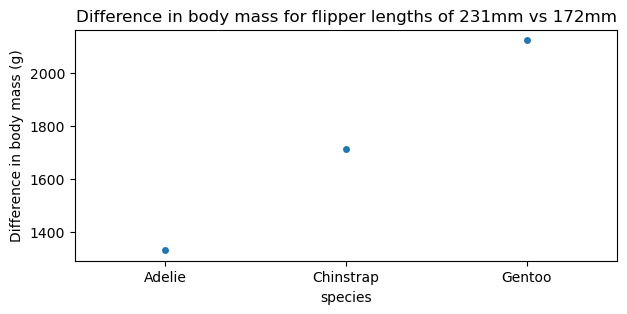

In [240]:
plt.figure(figsize=(7, 3))
sns.stripplot(
    x="species",
    y="preds",
    data=contrast_comparison,
    jitter=False,
    dodge=True
)
plt.ylabel("Difference in body mass (g)")
plt.title("Difference in body mass for flipper lengths of 231mm vs 172mm");

In [119]:
unique_bill_length = np.unique(data.bill_length_mm)
unique_species = np.unique(data.species)
mode_island = data.island.mode()

plus_flip_length = data.flipper_length_mm.unique() + data.flipper_length_mm.unique() / 2
minus_flip_length = data.flipper_length_mm.unique()  - data.flipper_length_mm.unique() / 2
flipper_length = np.concatenate((plus_flip_length, minus_flip_length))

In [120]:
import itertools

lists = [unique_species, unique_bill_length, flipper_length, mode_island]
cartesian_df = pd.DataFrame(
    list(itertools.product(*lists)), 
    columns=["species", "bill_length_mm", "flipper_length_mm", "island"]
)

In [121]:
cartesian_df

,species,bill_length_mm,flipper_length_mm,island
0,Adelie,32.1,271.5,Biscoe
1,Adelie,32.1,279.0,Biscoe
2,Adelie,32.1,292.5,Biscoe
3,Adelie,32.1,289.5,Biscoe
4,Adelie,32.1,285.0,Biscoe
...,...,...,...,...
52807,Gentoo,59.6,111.5,Biscoe
52808,Gentoo,59.6,106.0,Biscoe
52809,Gentoo,59.6,114.0,Biscoe
52810,Gentoo,59.6,113.0,Biscoe


In [122]:
cart_preds = model.predict(idata, data=cartesian_df, kind="mean", inplace=False)
cart_preds_mu = cart_preds.posterior.body_mass_g_mean.mean(("chain", "draw")).to_numpy()

cart_preds_df = pd.DataFrame({
    "species": cartesian_df.species,
    "bill_length_mm": cartesian_df.bill_length_mm,
    "flipper_length_mm": cartesian_df.flipper_length_mm,
    "island": cartesian_df.island,
    "preds": cart_preds_mu
})

#cart_preds_df = cart_preds_df.sort_values(by="bill_length_mm").reset_index(drop=True)

In [148]:
df = cart_preds_df.groupby(["species", "bill_length_mm"])['preds'].mean().reset_index()
df_diff = pd.DataFrame(df.groupby(["species"])['preds'].diff(1))
df_diff['species'] = df['species']
df_diff['bill_length_mm'] = df['bill_length_mm']
df_diff.head()

,preds,species,bill_length_mm
0,NaN,Adelie,32.1
1,69.598101,Adelie,33.1
2,27.839240,Adelie,33.5
3,34.799050,Adelie,34.0
4,27.839240,Adelie,34.4


In [ ]:
plt.figure(figsize=(7, 3))
sns.lineplot(
    x=df_diff.bill_length_mm,
    y=df_diff.preds,
    hue=df_diff.species
);

In [41]:
datagrid_1 = pd.DataFrame({
    "flipper_length_mm": data.flipper_length_mm - 0.5,
    "species": data.species,
    "bill_length_mm": data.bill_length_mm,
    "island": data.island.mode().to_numpy()[0]
})

minus_preds = model.predict(idata, data=datagrid_1, kind="mean", inplace=False)
minus_preds_mu = minus_preds.posterior.body_mass_g_mean.mean(("chain", "draw"))

datagrid_2 = pd.DataFrame({
    "flipper_length_mm": data.flipper_length_mm + 0.5,
    "species": data.species,
    "bill_length_mm": data.bill_length_mm,
    "island": data.island.mode().to_numpy()[0]
})

plus_preds = model.predict(idata, data=datagrid_2, kind="mean", inplace=False)
plus_preds_mu = plus_preds.posterior.body_mass_g_mean.mean(("chain", "draw"))

compare = plus_preds_mu - minus_preds_mu

In [44]:
preds_df = pd.DataFrame({
    "flipper_length_mm_plus": data.flipper_length_mm + 0.5,
    "flipper_length_mm_minus": data.flipper_length_mm - 0.5,
    "species": data.species,
    "bill_length_mm": data.bill_length_mm,
    "comparison": compare,
    "minus_preds": minus_preds_mu,
    "plus_preds": plus_preds_mu
})

preds_df = preds_df.sort_values(by="bill_length_mm").reset_index(drop=True)

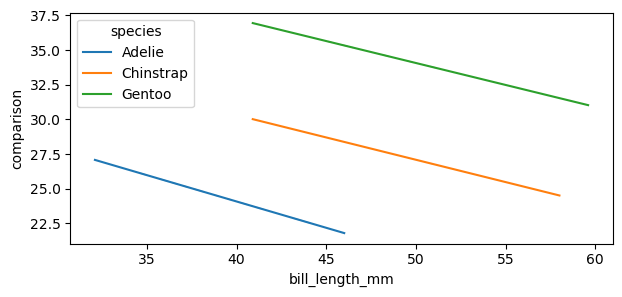

In [46]:
plt.figure(figsize=(7, 3))
sns.lineplot(
    x=preds_df.bill_length_mm,
    y=preds_df.comparison,
    hue=preds_df.species
);

### Titanic

In [151]:
dat = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/Stat2Data/Titanic.csv", index_col=0)

In [152]:
dat["PClass"] = dat["PClass"].str.replace("[st, nd, rd]", "", regex=True)
dat["PClass"] = dat["PClass"].str.replace("*", "0").astype(int)
dat["PClass"] = dat["PClass"].replace(0, np.nan)
dat["PClass"] = pd.Categorical(dat["PClass"], ordered=True)
dat["Sex"] = pd.Categorical(dat["Sex"]).codes

In [153]:
dat = dat.dropna(axis=0, how="any")

In [159]:
titanic_model = bmb.Model(
    "Survived ~ PClass * SexCode * Age", 
    data=dat, 
    family="binomial"
)
idata = titanic_model.fit(draws=1000, target_accept=0.95, random_seed=1234)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [155]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-6621.982,4994.819,-15950.763,2714.231,131.516,93.015,1442.0,2000.0,1.0
flipper_length_mm,39.260,26.228,-8.793,88.782,0.691,0.488,1441.0,2043.0,1.0
species[Chinstrap],358.032,2530.608,-4014.266,5460.335,60.581,42.844,1753.0,2431.0,1.0
species[Gentoo],-1941.339,2334.832,-6366.018,2371.530,57.724,41.311,1640.0,2117.0,1.0
flipper_length_mm:species[Chinstrap],3.917,13.561,-21.860,28.714,0.322,0.228,1772.0,2432.0,1.0
flipper_length_mm:species[Gentoo],10.627,10.799,-10.355,29.883,0.243,0.172,1964.0,2438.0,1.0
bill_length_mm,146.651,124.190,-77.265,382.820,3.329,2.354,1393.0,1808.0,1.0
flipper_length_mm:bill_length_mm,-0.380,0.648,-1.628,0.784,0.017,0.012,1383.0,1836.0,1.0
species:bill_length_mm[Chinstrap],-51.932,55.145,-157.283,48.558,1.328,0.939,1725.0,2259.0,1.0
species:bill_length_mm[Gentoo],-18.541,49.308,-110.659,73.099,1.159,0.820,1817.0,2149.0,1.0


In [156]:
grid_50_1_3 = pd.DataFrame({
    "Age": [50],
    "SexCode": [1],
    "PClass": [3]
})

grid_50_1_1 = pd.DataFrame({
    "Age": [50],
    "SexCode": [1],
    "PClass": [1]
})

grid_50_0_3 = pd.DataFrame({
    "Age": [50],
    "SexCode": [0],
    "PClass": [3]
})

grid_50_0_1 = pd.DataFrame({
    "Age": [50],
    "SexCode": [0],
    "PClass": [1]
})

In [157]:
def get_preds(idata, grids):
    preds = {}
    for i, grid in enumerate(grids):
        preds[i] = titanic_model.predict(idata, data=grid, kind="mean", inplace=False)
        preds[i] = preds[i].posterior.Survived_mean.mean(("chain", "draw")).to_numpy()[0]
    return preds

In [158]:
preds = get_preds(idata, [grid_50_1_3, grid_50_1_1, grid_50_0_3, grid_50_0_1])

KeyError: 'PClass'

In [24]:
comparison_df = pd.DataFrame({
    "PClass": [3, 1, 3, 1],
    "SexCode": [1, 1, 0, 0],
    "Age": [50, 50, 50, 50],
    "Survival": [preds[0], preds[1], preds[2], preds[3]]
})
comparison_df

,PClass,SexCode,Age,Survival
0,3,1,50,0.446254
1,1,1,50,0.957590
2,3,0,50,0.007755
3,1,0,50,0.246004


In [55]:
focal = comparison_df[["SexCode", "Age"]].drop_duplicates().reset_index(drop=True)

compare_probs_df = pd.DataFrame(
    comparison_df.groupby(["SexCode", "Age"])['Survival'].diff(1).dropna().reset_index(drop=True),
    )
compare_probs_df[["SexCode", "Age"]] = focal

In [150]:
compare_probs_df

NameError: name 'compare_probs_df' is not defined

In [149]:
plt.figure(figsize=(7, 3))
sns.stripplot(
    x=compare_probs_df.Age,
    y=compare_probs_df.Survival,
    hue=compare_probs_df.SexCode,
    dodge=True,
    jitter=False
)
plt.title("Difference in probs. of survival for contrast: 3rd $\\rightarrow$ 1st class")
plt.ylabel("Difference in Probs. of Survival");

NameError: name 'compare_probs_df' is not defined

<Figure size 700x300 with 0 Axes>